## Ctrl+F for 'adjust' to replace Path names etc

### Training and evaluating 5 Meuse MTS-LSTM
5 models are trained on Meuse basins, each time one basin is not included in training data and serves as test basin afterwards

1) Preparing basin txt files for training of 5 models 

2) Adjusting a configuration file template, training MTS-LSTM on 4 basins, evaluating mdoel on fifth basin 

3) Determine metrics for each test catchment and create a plot with Qobs and Qsim (first for daily, then for hourly results)

### Imports etc.

In [3]:
import pickle
import os
from pathlib import Path
import xarray as xr

import matplotlib.pyplot as plt
import pandas as pd

from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.utils.config import Config

import torch
from ruamel.yaml import YAML  

In [4]:
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import numexpr as ne

In [5]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


## Preparation of configuration file and basin list

- fill in work_dir

In [6]:
# adjust Path
work_dir = Path('C:/Users/kwilbrand/Katharina/My_MTS-LSTM') 
assert work_dir.exists()
os.chdir(work_dir)
os.getcwd()

'C:\\Users\\kwilbrand\\Katharina\\My_MTS-LSTM'

- fill in path to basin list txt files accordingly

In [6]:
# get all basin names for Meuse 
with open('data/basins_europe.txt', 'rb') as f:      # adjust Path
    basins = [line.decode().rstrip() for line in f]
    basins = [basin for basin in basins if basin.startswith('meuse')]

# prepare txt files with train and test basin(s) for the five model runs
for i, basin in enumerate(basins): 
    test_basin = basin
    
    # the model will be trained on all basins but the test basin 
    train_valid_basins = basins.copy()
    train_valid_basins.remove(test_basin)
    
    # save name of test basin to txt file
    with open('data/basin_txt_files/' + str(i).zfill(2) + '_' + test_basin + '_as_test.txt', 'w') as f:    # adjust Path
        f.write(test_basin)

    # save list of training basins to txt file
    with open('data/basin_txt_files/' + str(i).zfill(2) + '_train_basins.txt', 'w') as f:        # adjust Path
        f.write('\n'.join(train_valid_basins))

## Training & Evaluation

- fill in Path to configuration template accordingly (first line)
- fill in Path where to store adjusted configuration files (line 20)
- check that correct file is chosen for evaluation (line 29)

In [1]:
config_template_path= Path("configs/meuse_kmeans/21hyperparam_tuning_europe.yml")   # adjust Path
assert config_template_path.exists()

# train five models, each time excluding one basin
for i, basin in enumerate(basins):
    # adjust config 
    yaml = YAML()
    run_config = yaml.load(config_template_path)
    
    # add correct path to train and test basin files (adjust Path x3)
    run_config["train_basin_file"] = 'data/basin_txt_files/' + str(i).zfill(2) + '_train_basins.txt'
    run_config["validation_basin_file"] = 'data/basin_txt_files/' + str(i).zfill(2) + '_train_basins.txt'
    run_config["test_basin_file"] = 'data/basin_txt_files/' + str(i).zfill(2) + '_' + basin + '_as_test.txt'
    
    # add unique experiment name
    experiment_name = str(i).zfill(2) + basin + '_as_testbasin'
    run_config["experiment_name"] = experiment_name

    # save configuration file
    config_path = Path("configs/meuse_kmeans/" + experiment_name + ".yml")   # adjust Path
    yaml.dump(run_config, config_path)

    # start training
    run_config = Config(config_path)
    start_run(config_file=config_path)

    # evaluate
    runs_dir = work_dir / "runs"
    run_dir = list(runs_dir.glob("*/"))[:-2][-1]     # adjust so that correct file is chosen, depends on chosen experiment name
    tester = get_tester(cfg=run_config, run_dir=run_dir, period="test", init_model=True)
    results = tester.evaluate(save_results=True, metrics=run_config.metrics)


## Metrics and Plots
- check if correct run_dir is selected automatically (line 2 and 3)
- fill in names of Qobs and Qsim variables in xr dataset (line 6 an 7)
- chose a directory to save plots to (line 13)
- adjust Path and last model epoch to evaluate on (line 21)
- adjust Path to store metrics dataframe to (line 48)

In [2]:
# files = [name for name in os.listdir(runs_dir)][:-3]
# files

meuse_6 00_meuse_6_as_testbasin_2709_102009
meuse_13 01meuse_13_as_testbasin_2409_100557
meuse_701 02meuse_701_as_testbasin_2409_100844
meuse_702 03meuse_702_as_testbasin_2409_101132
meuse_703 04meuse_703_as_testbasin_2409_101420
Daily metrics:


dict_keys(['meuse_703'])

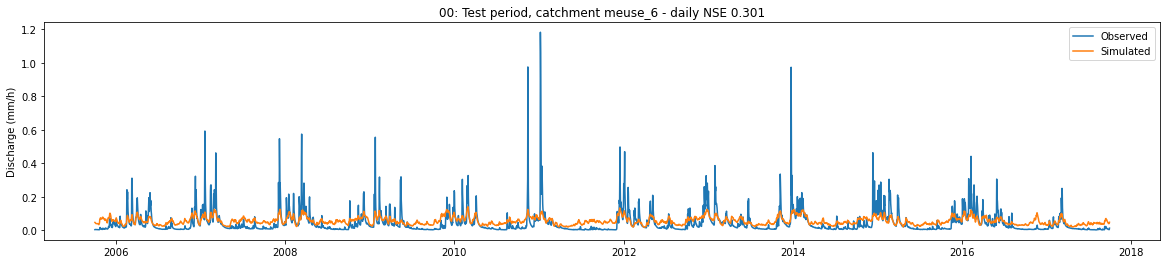

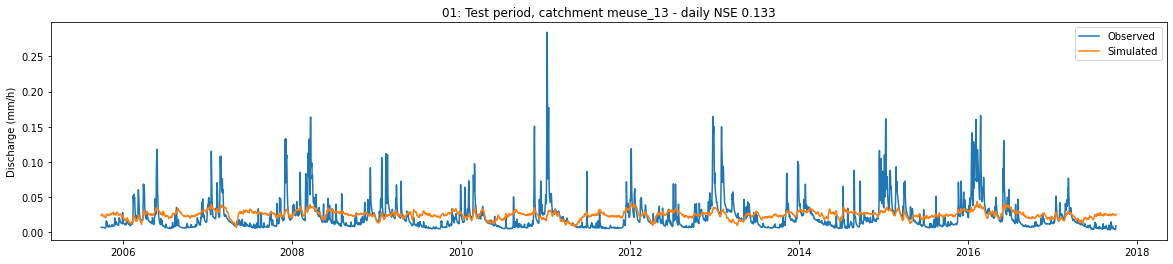

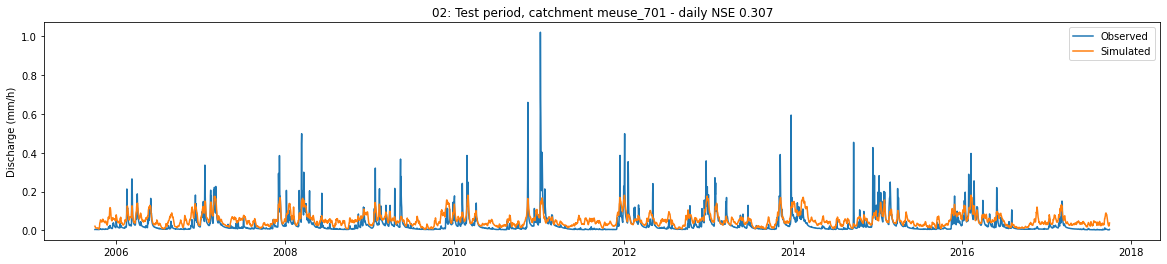

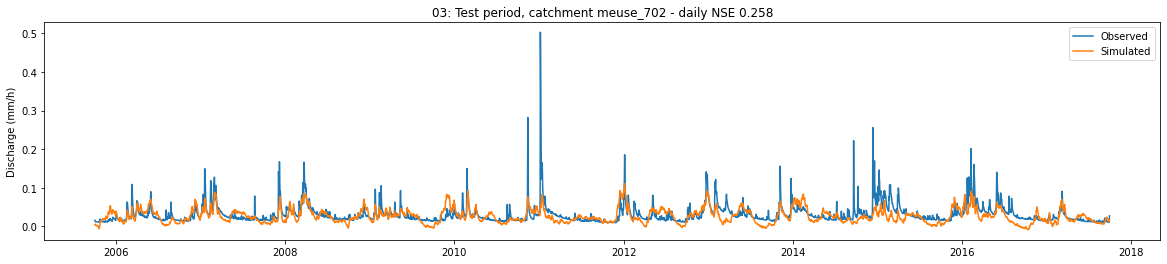

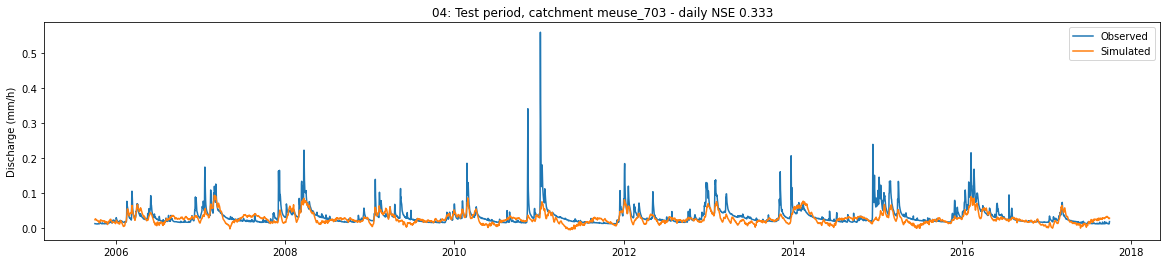

In [12]:
# check that only those files are chosen that you want to evaluate, depends on chsoen experiment-names
runs_dir = work_dir / "runs"
files = [name for name in os.listdir(runs_dir)][:-3]   

# names of dataset variables qsim and qobs
qobs_var = 'qobs_obs'
qsim_var = 'qobs_sim'

# dataframe to store metrics for each catchment
metrics_df = pd.DataFrame()

# directory to store figures of time-sereis plots with observed and simulated Q
plot_dir = Path('C:/Users/kwilbrand/Katharina/My_MTS-LSTM/runs/time-series_plots')
if plot_dir.exists() == False:
    os.mkdir(plot_dir)

for file in files:
    if not 'testbasin' in file:
        continue

    fp = 'C:/Users/kwilbrand/Katharina/My_MTS-LSTM/runs/' + file + '/test/model_epoch050/test_results.p' # adjust Path and model epoch
    
    # load results (dict: results[catchment_ID][frequency]['xr'])
    with open(fp, 'rb') as f:
        results = pickle.load(f)

    for catchm_ID in results.keys():
        # extract observations and simulations
        daily_qobs = results[catchm_ID]["1D"]["xr"][qobs_var]
        daily_qsim = results[catchm_ID]["1D"]["xr"][qsim_var]

        fig, ax = plt.subplots(figsize=(20,4))
        ax.plot(daily_qobs["date"], daily_qobs, label="Observed")
        ax.plot(daily_qsim["date"], daily_qsim, label="Simulated")
        ax.legend()
        ax.set_ylabel("Discharge (mm/h)")
        ax.set_title(f"{file[0:2]}: Test period, catchment {catchm_ID} - daily NSE {results[catchm_ID]['1D']['NSE_1D']:.3f}")
        plt.savefig(str(plot_dir) + '/daily_' + file[0:2] + '_' + catchm_ID)
        print(catchm_ID, file)

        # Calculate some metrics
        values = metrics.calculate_all_metrics(daily_qobs.isel(time_step=-1), daily_qsim.isel(time_step=-1))
        values['nr'] = file[0:2]
        values['catchment'] = catchm_ID
        df_temp = pd.DataFrame(values, index=[file[0:2] + catchm_ID])
        metrics_df = metrics_df.append(other=df_temp)
    
    with open('C:/Users/kwilbrand/Katharina/My_MTS-LSTM/runs/' + file + '/metrics_df_daily.pkl', 'wb') as f: # adjust Path
        pickle.dump(metrics_df, f, pickle.DEFAULT_PROTOCOL)


print("Daily metrics:")
metrics_df

meuse_6 00_meuse_6_as_testbasin_2709_102009
meuse_13 01meuse_13_as_testbasin_2409_100557
meuse_701 02meuse_701_as_testbasin_2409_100844
meuse_702 03meuse_702_as_testbasin_2409_101132
meuse_703 04meuse_703_as_testbasin_2409_101420
Hourly metrics:


,NSE,MSE,RMSE,KGE,Alpha-NSE,Beta-NSE,Pearson-r,FHV,FMS,FLV,Peak-Timing,nr,catchment
00meuse_6,0.230260,0.003790,0.061560,0.138240,0.299538,-0.199070,0.600277,-70.749405,-53.809079,-739.930982,NaN,00,meuse_6
01meuse_13,0.070520,0.000465,0.021565,0.011507,0.329503,0.048403,0.275316,-70.600281,-57.926433,-260.881248,NaN,01,meuse_13
02meuse_701,-1.799198,0.008510,0.092252,-1.026942,1.335686,1.204709,0.537619,-9.094771,-26.876349,-1048.905639,NaN,02,meuse_701
03meuse_702,-0.637683,0.001036,0.032188,0.325670,1.459341,-0.122064,0.516292,23.718580,113.783792,-1182.575526,NaN,03,meuse_702
04meuse_703,-0.608392,0.001170,0.034201,0.042023,0.670163,-0.854129,0.425466,-55.382627,1149.969347,100.000000,NaN,04,meuse_703


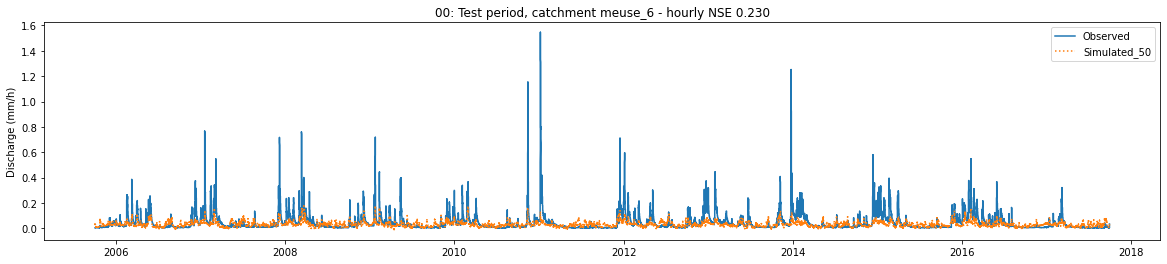

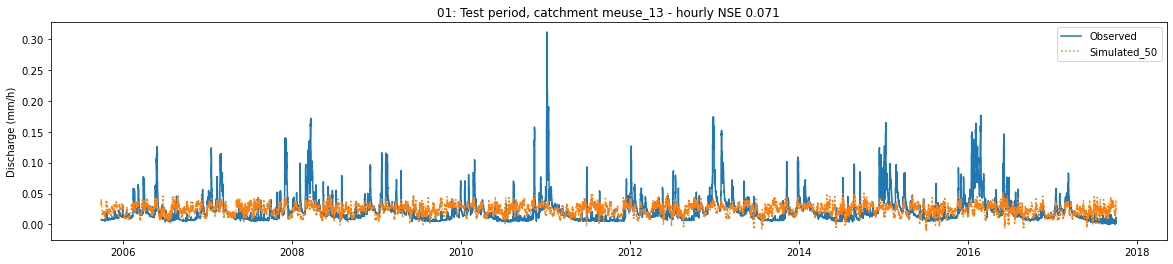

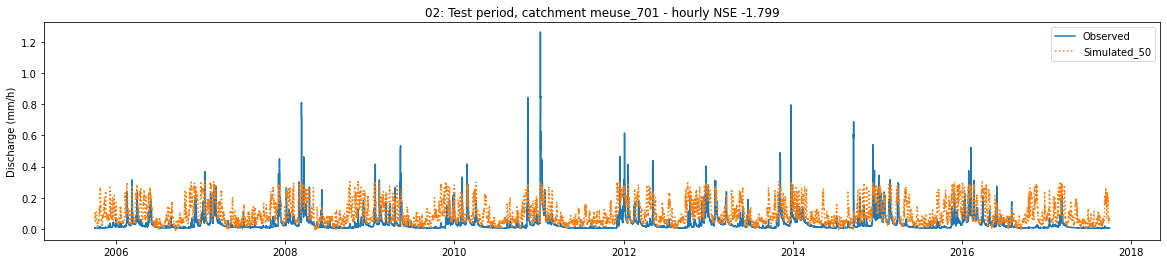

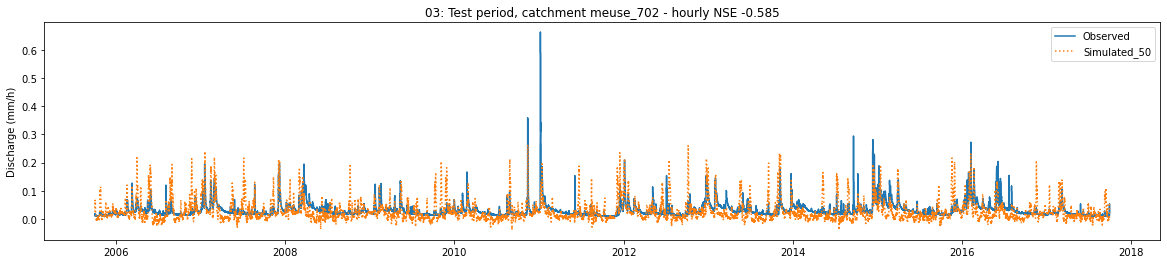

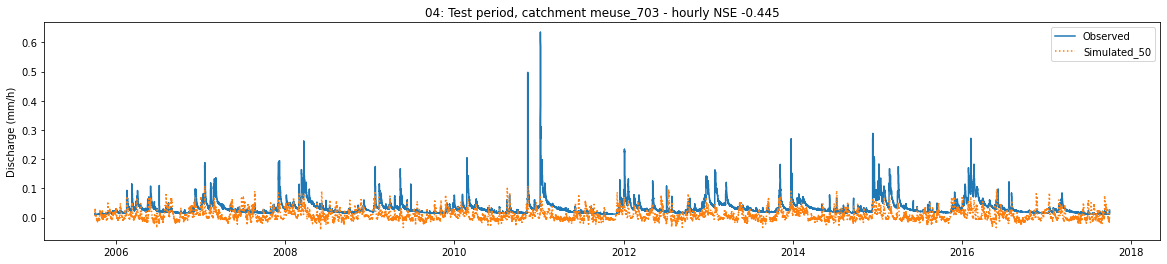

In [13]:
files = [name for name in os.listdir(runs_dir)][:-3]

# adjust names of dataset variables qsim and qobs
qobs_var = 'qobs_obs'
qsim_var = 'qobs_sim'

# dataframe to store metrics for each catchment
metrics_df = pd.DataFrame()

# directory to store figures of time-sereis plots with observed and simulated Q
plot_dir = Path('C:/Users/kwilbrand/Katharina/My_MTS-LSTM/runs/time-series_plots') # adjust Path
if plot_dir.exists() == False:
    os.mkdir(plot_dir)
    
for file in files:
    if not 'testbasin' in file:
        continue

    fp50 = 'C:/Users/kwilbrand/Katharina/My_MTS-LSTM/runs/' + file + '/test/model_epoch050/test_results.p' # adjust Path
    
    with open(fp50, 'rb') as f:
        results50 = pickle.load(f)

    for catchm_ID in results50.keys():
        if catchm_ID.startswith('meuse'):
            # extract observations and simulations
            hourly_xr = results50[catchm_ID]["1H"]["xr"]
            hourly_xr = hourly_xr.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            hourly_xr['datetime'] = hourly_xr.coords['date'] + hourly_xr.coords['time_step']
            
            hourly_qobs = hourly_xr[qobs_var]
            hourly_qsim_50 = hourly_xr[qsim_var]
            

            fig, ax = plt.subplots(figsize=(20,4))
            ax.plot(hourly_qobs["datetime"], hourly_qobs, label="Observed")
            ax.plot(hourly_qsim_50["datetime"], hourly_qsim_50, label="Simulated_50", ls=':')
            ax.legend()
            ax.set_ylabel("Discharge (mm/h)")
            print(catchm_ID, file)
            ax.set_title(f"{file[0:2]}: Test period, catchment {catchm_ID} - hourly NSE {results50[catchm_ID]['1H']['NSE_1H']:.3f}")
            plt.savefig(str(plot_dir) + '/hourly' + file[0:2] + '_' + catchm_ID)

            # Calculate some metrics
            values = metrics.calculate_all_metrics(hourly_qobs, hourly_qsim)
            values['nr'] = file[0:2]
            values['catchment'] = catchm_ID
            df_temp = pd.DataFrame(values, index=[file[0:2] + catchm_ID])
            metrics_df = metrics_df.append(other=df_temp)


    with open('C:/Users/kwilbrand/Katharina/My_MTS-LSTM/runs/' + file + '/metrics_df_hourly.pkl', 'wb') as f: # adjust Path
        pickle.dump(metrics_df, f, pickle.DEFAULT_PROTOCOL)

print("Hourly metrics:")
metrics_df